In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as nn_utils
import zuko
from torch.optim import lr_scheduler

from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
from lampe.plots import nice_rc, corner, mark_point
from lampe.utils import GDStep
from lampe.data import H5Dataset
from lampe.diagnostics import expected_coverage_mc

import h5py
import numpy as np

from datetime import datetime

ModuleNotFoundError: No module named 'zuko'

In [2]:
LOWER = torch.tensor([0  ,  0. ])
UPPER = torch.tensor([0.2 , 1. ])

#参数归一化与逆运算
def preprocess(theta: torch.Tensor) -> torch.Tensor:
    return 2 * (theta - LOWER) / (UPPER - LOWER) - 1

def postprocess(theta: torch.Tensor) -> torch.Tensor:
    return (theta + 1) / 2 * (UPPER - LOWER) + LOWER

# 模型搭建

In [3]:
data_set_dir='/home/lichunyue/sty/train_p/'

这段代码主要是在处理参数归一化（Normalization）和逆归一化（Denormalization）的操作，常用于机器学习或深度学习中对数据的预处理和后处理。此外，还提供了数据集的目录位置，这可能是用于模型训练的数据集。让我们逐一解析：

1. **参数归一化与逆运算**:
   - `LOWER` 和 `UPPER` 分别定义了归一化时参数的下界和上界。在这个例子中，下界是`[0, 0]`，上界是`[0.2, 1]`。这些界限用于将参数`theta`归一化到一个特定的范围内，在本例中是`[-1, 1]`。
   
   - `preprocess` 函数执行归一化操作。它首先计算`theta`与下界`LOWER`的差值，然后将差值的两倍除以上界和下界的差值，最后从结果中减去1。这样，原始的`theta`值就被映射到了`[-1, 1]`的范围内。
   
   - `postprocess` 函数执行逆归一化操作。它是归一化过程的反向操作，用于将归一化后的`theta`值还原回原始的数值范围。这通过先将`theta`加1然后除以2，再乘以上界和下界的差值，最后加上下界`LOWER`来实现。

2. **模型搭建**:
   - `data_set_dir`变量定义了一个字符串，指向存储训练数据的目录。在本例中，数据集的目录是`'/home/lichunyue/sty/train_p/'`。这表明可能接下来的代码会使用这个目录下的数据进行一些机器学习或深度学习模型的训练。

总结来说，这段代码的主要作用是定义了一种对参数进行归一化和逆归一化的方法，这在训练深度学习模型时非常常见，因为归一化可以帮助加快模型的收敛速度并提高模型的性能。同时，给出的数据集目录说明可能会有后续的模型训练步骤。

In [13]:
#非采样器的
torch.backends.cudnn.deterministic = True #禁用 cuDNN 的随机性，从而保证每次运行的结果都是相同的。

aaaaa=[]

import gc
#tensor(-1.5224, device='cuda:0')
#for act in [nn.ReLU]:
#  for f in [0.0001]:
#    for weight_decay in [0]:
#       for liu in [zuko.flows.NSF]:
#        for transfomr in [12]:#特征提取的blocks
#         for num in [2048]:
#          for trans in [18]:#NF的残差块--画图的
#           for beishu in [1024]:
#

for act in [nn.ReLU]:
  for f in [0.0001]:
    for weight_decay in [0]:
       for liu in [zuko.flows.NSF]:
        for transfomr in [7]:#特征提取的blocks
         for num in [4096]:
          for trans in [9]:#NF的残差块--画图的
           for beishu in [2048]:
            now= datetime.now()
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.jia_relu(self.layer(x)+residual)
                
                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.layer(x)+residual

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x



                

            torch.manual_seed(2234)#重置参数，在循环里面可以保证可以复现
            
            model= ResNet(in_channels=4,classes=2).cuda()#beishu是残差网络输出尺寸（npe的输入参数）
            model.apply(weight_init)
            
            optimizer = optim.AdamW(model.parameters(), lr=f,weight_decay=weight_decay)#学习率！！！！！！！！！！！
            #在优化器选项里添加正则化,weight_decay=0.01，l2正则化

            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)#学习率衰减
            #https://zhuanlan.zhihu.com/p/363338422

            step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping,有了他不用optimizer.step
            loss = nn.MSELoss()

            list_los=[]
            list_losvail=[]
        
            with tqdm(range(2000), unit='epoch') as tq:#epoch
                best_loss = np.inf#早停
                best_model_weights = None
                patience=30#10个周期不降就停
                i_all=0
                num=10000#总数
                num_v=2000
                datast=20#batch_size
                nnum=num//datast
                nnum_v=num_v//datast
                
                for epoch in tq:
                    optimizer.zero_grad()
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    all_x = torch.tensor(np.load(data_set_dir+f'train_x_{i_all}.npy'),dtype=torch.float32)
                    all_y = torch.tensor(np.load(data_set_dir+f'train_can_{i_all}.npy'),dtype=torch.float32)

                    all_x_vail = torch.tensor(np.load(data_set_dir+f'vail_x_{i_all}.npy'),dtype=torch.float32)
                    all_y_vail = torch.tensor(np.load(data_set_dir+f'vail_can_{i_all}.npy'),dtype=torch.float32)

                    i_all+=1
                    if i_all>=400:
                        i_all=0
                                              
                                              

                    model.train()
                    losses = torch.stack([
                        step(loss(model(all_x[i].cuda()), preprocess(all_y[i]).cuda()))
                        for i in range(nnum) # 这样写是遍历全部元素，实例那样是因为他是采样器
                    ])
                    
                    del all_x,all_y
                    
                    model.eval()
                    with torch.no_grad():
                        val_losses = torch.stack([
                            loss(model(all_x_vail[i].cuda()), preprocess(all_y_vail[i]).cuda())
                            for i in range(nnum_v)
                        ])
                    
                    scheduler.step()#学习率衰减
                    
                    tq.set_postfix(loss=losses.mean().item(), val_loss=val_losses.mean().item())

                    del all_x_vail,all_y_vail
                    
                    los=losses.mean().item()#类型不对，所以换名字
                    losval=val_losses.mean().item()#类型不对，所以换名字
                    
                    list_los.append(los)#话损失函数图
                    list_losvail.append(losval)#话损失函数图

                    # 储存监视
                    data1 = list_los
                    data2 = list_losvail
                    last= now
                    now = datetime.now()
                    # 打开一个文件用于写入
                    file = open('/home/suntianyang/GW_lens/resnet_can.txt', 'w')
                    file.write('last_last:'+str(last) + '\n')
                    file.write('___last__:'+str(now) + '\n')
                    
                    # 将每个元素写入文件中
                    for item1, item2 in zip(data1, data2):
                        file.write(str(item1) + ' ' + str(item2) + '\n')
                    
                    # 关闭文件
                    file.close()
                    
                    del losses,data1,data2
                    
                    if losval < best_loss:
                        best_loss = losval
                        epochs_without_improvement = 0
                        best_model_weights = model.state_dict()
                    else:
                        epochs_without_improvement += 1

                    # 如果验证集上的损失连续patience个epoch没有提高，则停止训练
                    if epochs_without_improvement == patience:
                        model.load_state_dict(best_model_weights)
                        print('Early stopping at epoch {}...'.format(epoch-patience+1))
                        break

            aaaaa.append('act{}学习率{},正则化{},,参数数目{},参数层数{},流层{},中间层{},最佳损失{},训练周期{}'.format(act,f,weight_decay,num,transfomr,trans,beishu,list_los[-1-patience],len(list_los)-patience))
            print('act{}学习率{},正则化{},,参数数目{},参数层数{},流层{},中间层{},最佳损失{},训练周期{}'.format(act,f,weight_decay,num,transfomr,trans,beishu,list_los[-1-patience],len(list_los)-patience))

  9%|▉         | 182/2000 [14:03:59<140:30:35, 278.24s/epoch, loss=0.108, val_loss=0.0984]

Early stopping at epoch 153...
act<class 'torch.nn.modules.activation.ReLU'>学习率0.0001,正则化0,,参数数目10000,参数层数7,流层9,中间层2048,最佳损失0.11487556993961334,训练周期153


这段代码是一个深度学习训练过程的完整示例，使用PyTorch框架构建并训练一个残差网络（ResNet）。它涉及数据预处理、模型定义、训练循环、验证、以及早停机制。以下是详细的分析：

### 数据预处理
- `preprocess` 和 `postprocess` 函数用于数据的归一化和逆归一化操作，这有助于模型更好地学习。

### 模型设置
- 设置`torch.backends.cudnn.deterministic`为`True`，确保使用cuDNN（CUDA深度神经网络库）时的结果是可复现的。
- 初始化一个空列表`aaaaa`，可能用于存储模型训练后的统计信息或结果。

### 训练参数和模型初始化
- 通过多重循环设置了一系列的训练参数组合，如激活函数、学习率、权重衰减等。这段代码展示了一个特定的参数组合，但注释掉的部分表明可能有更多组合被考虑。
- 定义了一个权重初始化函数`weight_init`，用于对卷积层和线性层的权重进行初始化，使用`xavier_uniform_`方法。

### 模型定义
- 定义了`Bottleneck`类和`ResNet`类。`Bottleneck`类是残差网络的一个基本构建块，`ResNet`类则是根据这些构建块搭建的完整网络。
- `ResNet`模型包括初始的卷积层、池化层、多个`Bottleneck`层，以及最后的平均池化和线性分类器。这是一个典型的深度残差网络结构。

### 训练过程
- 设定了随机种子以保证结果的可复现性。
- 初始化模型并应用权重初始化。然后，定义优化器（这里是AdamW），学习率调度器，以及损失函数。
- 实现了一个训练循环，其中包括模型的前向传播、损失计算、梯度反向传播（通过自定义的`step`函数实现，可能包含梯度裁剪）。
- 在每个epoch结束时，记录训练和验证损失，以及进行学习率调度。
- 使用早停机制以避免过拟合，当验证损失在连续`patience`个epoch中没有改善时停止训练。

### 记录和监控
- 训练过程中，相关的统计信息被记录在一个文本文件中，例如，每个epoch的损失值。
- 最终，将模型性能相关的统计信息添加到`aaaaa`列表中，并打印出来。

整个代码段展示了深度学习中一个常见的实践流程：从数据处理到模型训练、验证、以及最终的性能评估。此代码用于训练一个用于分类的残差网络，具体应用的细节（如数据集和类别数）则在代码之外定义。

In [14]:
torch.save(model, f'./net_ann_2/NPE_mid_t_lens_res_can_all.pth')

In [7]:
#重置网络参数，方便for循环调参
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0.0)

class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Linear(2, 128) 
        self.norm1 = nn.LayerNorm(128)
        
        self.layer2 = nn.Linear(128, 128)
        self.norm2 = nn.LayerNorm(128)

        self.layer3 = nn.Linear(128, 128)
        self.norm3 = nn.LayerNorm(128)
        
        self.layer4 = nn.Linear(128, 1)
        
        self.dropout = nn.Dropout(p=0.2)
        #self.leakyrelu = nn.LeakyReLU(negative_slope=0.01)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.layer1(x)) 
        #x = self.dropout(x)
        x = self.norm1(x)
        
        x = self.relu(self.layer2(x))
        #x = self.dropout(x)
        x = self.norm2(x)
        
        x = self.relu(self.layer3(x))
        #x = self.dropout(x)
        x = self.norm3(x)
        
        x = self.layer4(x)
        return x
    


这段代码展示了一个新的神经网络`MyNetwork`的定义，这是一个相对简单的全连接神经网络（Fully Connected Network，或称为密集网络），它由多个线性层（`nn.Linear`）、归一化层（`nn.LayerNorm`）、激活函数（`nn.ReLU`和`nn.LeakyReLU`），以及Dropout层组成。这个网络结构被设计用于处理某种回归任务（最后一层的输出维度为1，常见于回归问题）。以下是对各部分功能的详细解读：

1. **权重初始化函数** (`weight_init`): 这个函数使用Xavier均匀初始化方法来初始化线性层的权重，并将偏置项初始化为0。这种初始化方法适用于保持输入和输出的方差一致，有助于深层网络的训练。

2. **网络结构**:
   - **输入层**：`self.layer1`是输入层，接受二维输入（例如，可能是某个特征的两个维度），并将其转换为128维的表示。
   - **隐藏层**：接下来有三个隐藏层（`self.layer2`, `self.layer3`, `self.layer4`），每个都是128维到128维的线性变换，除了最后一个线性层将维度从128降到1，用于输出预测结果。每个线性层后都紧跟一个归一化层（`LayerNorm`）和Dropout层，以增强模型的泛化能力和防止过拟合。
   - **激活函数**：使用了ReLU激活函数来增加非线性，使得模型能够学习更复杂的函数映射。在某些注释中还提到了LeakyReLU，但在实际的`forward`方法中并未使用，可能是一个备选的激活函数。
   - **Dropout层**：在每个归一化后都使用了Dropout策略，通过随机丢弃一部分神经元的输出来防止模型对训练数据的过拟合，`p=0.2`表示每个神经元有20%的概率被丢弃。

3. **前向传播** (`forward`方法): 定义了数据通过网络的方式。数据首先通过输入层，然后依次通过三个隐藏层，每个隐藏层后都进行了ReLU激活、Dropout和层归一化，最终通过输出层生成预测结果。

4. **模型保存**: 使用`torch.save`函数保存了之前定义的ResNet模型，这表明可能在多个模型中进行选择和测试，`MyNetwork`可能是另一种尝试，用于与之前的模型进行对比或提供不同的预测能力。

这个网络结构展示了一个典型的用于回归任务的神经网络设计，通过层间的线性变换、非线性激活、归一化和正则化，实现了对输入特征的高级抽象和映射。

In [8]:
def get_wave_plus_gaosnoise_t_gen_cai(data):
    samples_all=torch.zeros((data.shape[0],2))
    for i in range(data.shape[0]):
        model.eval()
        with torch.no_grad():
            samples = model(data[i].cuda()).cpu()

        samples_all[i,0]=samples[0,0]
        samples_all[i,1]=samples[0,1]
            
    return samples_all

这个函数`get_wave_plus_gaosnoise_t_gen_cai`旨在通过之前定义的模型（假定是`MyNetwork`或者可能是`ResNet`）为输入数据生成样本，其中特别处理了模型的输出以填充到`samples_all`张量中。下面是对其工作原理的逐步解释：

1. **输入参数**:
   - `data`：预期为一个张量，其形状为`(n, ...)`，其中`n`是样本数量，后续维度依赖于模型的输入要求。例如，如果是`ResNet`模型，后续维度可能是通道数、时间序列长度等。

2. **初始化输出张量**:
   - `samples_all`：这是一个全零张量，形状为`(data.shape[0], 2)`，用于存储每个输入样本经过模型处理后的输出。这里假设模型的输出有两个维度，可能对应于某种双重预测任务（例如，预测两个不同的特征或标签）。

3. **生成样本**:
   - 函数通过遍历`data`张量中的每个样本，将每个样本单独传递给模型进行预测。
   - 在对模型调用`.eval()`方法后，使用`torch.no_grad()`上下文管理器来禁用梯度计算，这是在评估/推理模式中常见的做法，用于减少内存使用并加速计算。
   - 模型的输出被假定为具有形状`(1, 2)`的张量，即对于每个输入样本，模型生成两个输出值。这些值随后被提取并填充到`samples_all`张量的对应位置。

4. **返回值**:
   - 函数返回`samples_all`张量，其中包含了对于输入数据集中每个样本，经过模型预测得到的两个输出值。

这个函数的主要作用是利用训练好的模型对一批数据进行批量推理，并收集模型的预测结果。它适用于需要对多个样本进行快速推理并整理结果的场景，如评估模型性能、生成预测结果等。

In [26]:
import gc
aaaaa=[]
torch.set_default_dtype(torch.float32)#更改默认精度（e指数需要高精度）
torch.backends.cudnn.deterministic = True #禁用 cuDNN 的随机性，从而保证每次运行的结果都是相同的。
torch.manual_seed(3234)#重置参数，在循环里面可以保证可以复现

f=2e-3
weight_decay=0.0000
torch.manual_seed(2234)#重置参数，在循环里面可以保证可以复现

estimator = MyNetwork().cuda()
estimator.apply(weight_init)
optimizer = optim.AdamW(estimator.parameters(), lr=f,weight_decay=weight_decay)#学习率！！！！！！！！！！！
#在优化器选项里添加正则化,weight_decay=0.01，l2正则化
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)#学习率衰减
#https://zhuanlan.zhihu.com/p/363338422
step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping,有了他不用optimizer.step
loss = nn.BCEWithLogitsLoss()
list_los=[]
list_val_los=[]
#非采样器的
torch.backends.cudnn.deterministic = True #禁用 cuDNN 的随机性，从而保证每次运行的结果都是相同的。

aaaaa=[]
now= datetime.now() 

with tqdm(range(2000), unit='epoch') as tq:#epoch
    best_loss = np.inf#早停
    best_model_weights = None
    patience=15#10个周期不降就停
    i=0
    i_all=0
    num=10000#总数
    num_v=2000
    datast=20#batch_size
    nnum=num//datast
    nnum_v=num_v//datast

    list_los=[]
    list_losvail=[]
    
    for epoch in tq:
        optimizer.zero_grad()
        gc.collect()
        torch.cuda.empty_cache()

        all_x = torch.tensor(np.load(data_set_dir+f'train_x_{i_all}.npy'),dtype=torch.float32).reshape(num,1,4,4096*10)
        all_x=get_wave_plus_gaosnoise_t_gen_cai(all_x).reshape(nnum,datast,2)
        all_y = torch.tensor(np.load(data_set_dir+f'train_y_{i_all}.npy'),dtype=torch.float32)

        
        all_x_vail = torch.tensor(np.load(data_set_dir+f'vail_x_{i_all}.npy'),dtype=torch.float32).reshape(num_v,1,4,4096*10)
        all_x_vail=get_wave_plus_gaosnoise_t_gen_cai(all_x_vail).reshape(nnum_v,datast,2)
        all_y_vail = torch.tensor(np.load(data_set_dir+f'vail_y_{i_all}.npy'),dtype=torch.float32)
        
        i_all+=1
        if i_all>=400:
            i_all=0
        
        
        estimator.train()
        losses = torch.stack([
            step(loss(estimator(all_x[i].cuda()), (all_y[i]).cuda()))
            for i in range(nnum) # 这样写是遍历全部元素，实例那样是因为他是采样器
        ])
        
        del all_x,all_y
        
        estimator.eval()
        with torch.no_grad():
            val_losses = torch.stack([
                loss(estimator(all_x_vail[i].cuda()), (all_y_vail[i]).cuda())
                for i in range(nnum_v)
            ])
        
        scheduler.step()#学习率衰减
        
        tq.set_postfix(loss=losses.mean().item(), val_loss=val_losses.mean().item())

        del all_x_vail,all_y_vail
        
        los=losses.mean().item()#类型不对，所以换名字
        losval=val_losses.mean().item()#类型不对，所以换名字
        
        list_los.append(los)#话损失函数图
        list_losvail.append(losval)#话损失函数图

        # 储存监视
        data1 = list_los
        data2 = list_losvail
        last= now
        now = datetime.now()
        # 打开一个文件用于写入
        file = open('/home/suntianyang/GW_lens/resnet_can_p.txt', 'w')
        file.write('last_last:'+str(last) + '\n')
        file.write('___last__:'+str(now) + '\n')
        
        # 将每个元素写入文件中
        for item1, item2 in zip(data1, data2):
            file.write(str(item1) + ' ' + str(item2) + '\n')
        
        # 关闭文件
        file.close()
        
        del losses,data1,data2
        
        if losval < best_loss:
            best_loss = losval
            epochs_without_improvement = 0
            best_model_weights = estimator.state_dict()
        else:
            epochs_without_improvement += 1

        # 如果验证集上的损失连续patience个epoch没有提高，则停止训练
        if epochs_without_improvement == patience:
            estimator.load_state_dict(best_model_weights)
            print('Early stopping at epoch {}...'.format(epoch-patience+1))
            break
            
aaaaa.append('act{}学习率{},正则化{},,参数数目{},参数层数{},流层{},中间层{},最佳损失{},训练周期{}'.format(act,f,weight_decay,num,transfomr,trans,beishu,list_los[-1-patience],len(list_los)-patience))
print('act{}学习率{},正则化{},,参数数目{},参数层数{},流层{},中间层{},最佳损失{},训练周期{}'.format(act,f,weight_decay,num,transfomr,trans,beishu,list_los[-1-patience],len(list_los)-patience))

  2%|▏         | 30/2000 [1:53:05<123:46:52, 226.20s/epoch, loss=0.0808, val_loss=0.0757]

Early stopping at epoch 16...


NameError: name 'act' is not defined

这段代码描述了使用自定义的`MyNetwork`模型进行训练的完整流程，具体包括准备数据、设置训练环境、训练循环、早停策略以及结果记录。这个过程主要用于解决某个具体的机器学习任务，如分类或回归。以下是详细分析：

1. **初始化和设置**:
   - 设置默认的数据类型为`torch.float32`以提高计算效率。
   - 通过`torch.backends.cudnn.deterministic = True`和`torch.manual_seed`来确保实验的可复现性。
   - 创建模型实例`estimator`并将其移至CUDA设备上（假定可用）进行训练。
   - 使用`weight_init`函数对`estimator`的权重进行初始化。
   - 设置优化器（`AdamW`），学习率调度器（`ExponentialLR`），损失函数（`BCEWithLogitsLoss`），以及梯度裁剪的步骤（`GDStep`）。

2. **训练循环**:
   - 使用`with tqdm(range(2000), unit='epoch')`创建一个进度条，表示训练过程将进行2000个epoch，除非提前停止。
   - 在每个epoch中，首先对训练和验证数据进行预处理和加载，然后执行一次前向传播和反向传播以更新模型参数。
   - 应用`get_wave_plus_gaosnoise_t_gen_cai`函数对输入数据进行处理，该函数似乎是对数据做了一些特定的转换或增加噪声，然后重新调整形状以适配模型的输入要求。
   - 在每个epoch结束时，评估训练损失和验证损失，并根据这些损失来决定是否继续训练。

3. **早停策略**:
   - 如果验证损失在连续`patience`个epoch中没有改善，则停止训练。这是防止过拟合并确保模型在验证集上有最佳表现的常用方法。

4. **结果记录和输出**:
   - 将每个epoch的训练损失和验证损失记录到列表中，并定期将这些损失值写入文件，方便后续分析。
   - 如果在某个epoch中达到了更低的验证损失，更新最佳模型权重，以便在训练结束后可以恢复这个最佳模型。

这个过程非常典型，涵盖了使用深度学习模型进行训练时的许多关键步骤和最佳实践。

In [27]:
torch.save(estimator,f'./net_ann_2/NPE_mid_t_lens_res_can_hou.pth')

这行代码执行了模型的保存操作，将训练完成的`estimator`模型保存到文件系统中。这使得模型可以在未来被重新加载和使用，无需重新训练。具体地：

- `torch.save(estimator, f'./net_ann_2/NPE_mid_t_lens_res_can_hou.pth')`: 这个函数调用保存了`estimator`对象（即训练好的模型）到指定的路径。文件路径和名称为`./net_ann_2/NPE_mid_t_lens_res_can_hou.pth`，这通常表示该文件位于当前工作目录的`net_ann_2`子目录中，文件名为`NPE_mid_t_lens_res_can_hou.pth`。

### 关键点
- **模型持久化**：这一步是模型训练流程的常见部分，通过保存模型，您可以在任何时候重新加载模型进行预测、继续训练或进一步分析。
- **文件路径**：路径`./net_ann_2/`建议该目录是专门用来存储网络模型的。通过给文件命名，您可以推断该模型可能与某种中间阶段的实验有关，或是针对特定任务的一个变体。
- **文件格式**：保存的文件使用`.pth`扩展名，这是PyTorch中常用的格式来保存模型。这种格式是二进制的，包含了模型的结构以及参数。

保存模型后，您可以使用`torch.load()`函数来重新加载模型，用于进一步的预测、分析或继续训练。例如，加载模型的代码可能如下所示：

```python
estimator = torch.load('./net_ann_2/NPE_mid_t_lens_res_can_hou.pth')
```

加载模型后，您可以将其置于评估模式（使用`.eval()`方法），然后使用它进行预测或执行其他任务。

# 训练

# 测试

In [28]:
def weight_init(m):
    if isinstance(m, (nn.Conv1d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
        nn.init.constant_(m.bias.data, 0.0)

class Bottlrneck(torch.nn.Module):
    def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
        super(Bottlrneck, self).__init__()
        self.stride = 1
        if downsample == True:
            self.stride = 2
        #在这里添加BatchNorm1d和Dropout是最合适的
        self.layer = torch.nn.Sequential(
            torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
            torch.nn.BatchNorm1d(Med_channel),
            torch.nn.ReLU(),
            torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
            torch.nn.BatchNorm1d(Med_channel),
            #torch.nn.ReLU(),
            torch.nn.Conv1d(Med_channel, Out_channel, 1),
            torch.nn.BatchNorm1d(Out_channel),
            #torch.nn.ReLU(),
        )

        if In_channel != Out_channel:
            self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
        else:
            self.res_layer = None

        self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

    def forward(self,x):
        if self.res_layer is not None:
            residual = self.res_layer(x)
        else:
            residual = x
        return self.jia_relu(self.layer(x)+residual)
    
    def forward(self,x):
        if self.res_layer is not None:
            residual = self.res_layer(x)
        else:
            residual = x
        return self.layer(x)+residual

class ResNet(torch.nn.Module):
    def __init__(self,in_channels=1,classes=5):
        super(ResNet, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
            torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

            Bottlrneck(64,64,256,False),
            Bottlrneck(256,64,256,False),
            Bottlrneck(256,64,256,False),#256*x/4*x/4



            Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
            Bottlrneck(512,128,512, False),
            Bottlrneck(512,128,512, False),
            Bottlrneck(512,128,512, False),



            Bottlrneck(512,256,1024, True),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),



            Bottlrneck(1024,512,2048, True),
            Bottlrneck(2048,512,2048, False),
            Bottlrneck(2048,512,2048, False),

            torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(2048,classes)#变成每类特征的信息
        )
        

    def forward(self,x):
        x = self.features(x)
        x = x.view(-1,2048)
        x = self.classifer(x)
        return x

model=torch.load(f'./net_ann_2/NPE_mid_t_lens_res_can_all.pth')
model.eval();

In [ ]:
estimator=torch.load(f'/home/suntianyang/work5/ligo/net_ann_2/NPE_mid_t_lens_res_can_hou.pth')
estimator.eval()

在这一部分的代码中，你首先定义了一个权重初始化函数`weight_init`和两个深度学习模型类——`Bottlrneck`和`ResNet`，然后加载了之前保存的两个模型状态。

### 权重初始化函数 `weight_init`
这个函数用于初始化模型的权重，适用于卷积层（`nn.Conv1d`）和全连接层（`nn.Linear`）。它使用了Xavier均匀初始化方法来初始化权重，偏置则初始化为0。这种初始化方法有助于在训练深度神经网络时保持激活函数的输出分布的一致性，促进模型的快速收敛。

### 模型定义
#### `Bottlrneck` 类
这个类定义了残差网络中的一个基本单元，即瓶颈层（Bottleneck layer），它通过一系列的卷积层和批标准化层构建，可选地包含跨层连接（如果输入和输出通道数不同）。这种结构有助于深度神经网络中信息的流动，并且可以减轻梯度消失或爆炸的问题。

#### `ResNet` 类
这个类定义了一个基于瓶颈层构建的残差网络，它通过堆叠多个`Bottlrneck`单元构建整个网络的特征提取部分，然后通过自适应平均池化层（`AdaptiveAvgPool1d`）和一个全连接层（`Linear`）来完成最终的分类任务。这个结构是深度学习中广泛使用的模型架构之一，特别擅长处理图像识别等任务。

### 模型加载和评估
最后，你使用`torch.load`加载了之前训练好并保存的模型状态。首先是`NPE_mid_t_lens_res_can_all.pth`，然后是`NPE_mid_t_lens_res_can_hou.pth`。加载后，通过调用`.eval()`方法将这两个模型置于评估模式，这是在模型评估或推理时常用的做法，以禁用模型中的Dropout和BatchNorm等只在训练时有效的层。

这段代码展示了深度学习实践中常见的一些技术和步骤，包括模型定义、权重初始化、模型保存和加载，以及模型评估准备。这些是构建和评估深度学习模型过程中的关键步骤。

# 保存

In [49]:
from sklearn.metrics import roc_curve, auc
import gc

In [45]:
def get_wave_plus_gaosnoise_t_gen_cai(data):
    samples_all=torch.zeros((data.shape[0],2))
    for i in range(data.shape[0]):
        model.eval()
        with torch.no_grad():
            samples = model(data[i].unsqueeze(0).cuda()).cpu()

        samples_all[i,0]=samples[0,0]
        samples_all[i,1]=samples[0,1]
            
    return samples_all

/tmp/ipykernel_231880/2743410634.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)


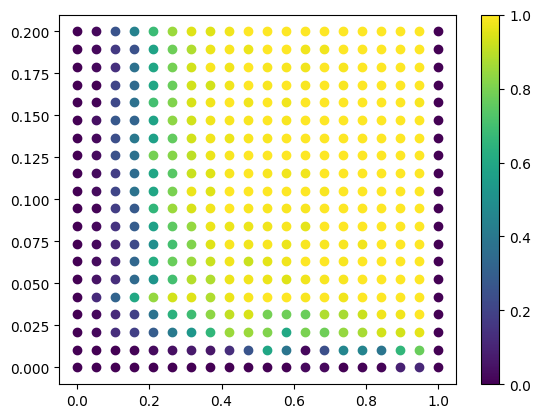

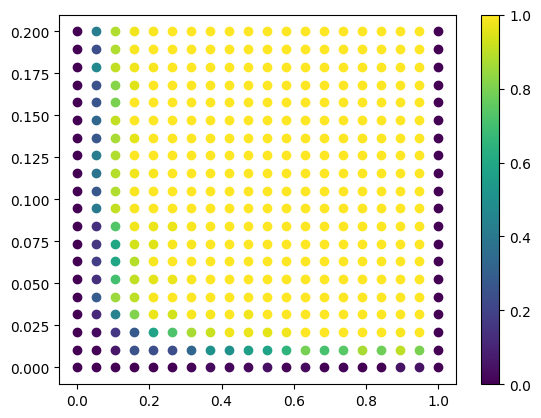

In [53]:
Z_L=0
for SNRRR in [16,24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            
            all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_PM_data_{I_tt}_{dtt}_{SNRRR}.npy')
            all_x_vail=torch.tensor(all_x_vail_data,dtype=torch.float32)
            all_x_vail=get_wave_plus_gaosnoise_t_gen_cai(all_x_vail).reshape(-1,2)
            all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)

            y_pre_all=[]
            for i in range(100):
                estimator.eval()
                with torch.no_grad():
                    #print(all_x_vail[i].dtype)
                    y_pre = torch.sigmoid(estimator(all_x_vail[i].cuda()))
                y_pre_all.append(float(y_pre))
            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)


                        
    plt.colorbar()
    plt.show()

这段代码主要执行了以下几个步骤，用于评估和可视化两个模型（`model`和`estimator`）对特定数据集的预测性能：

### 函数定义：`get_wave_plus_gaosnoise_t_gen_cai(data)`
这个函数接受一批输入数据`data`，对每个样本调用`model`生成预测值，然后返回一个新的包含所有样本预测结果的张量`samples_all`。这个函数已经在之前的代码段中被定义过。

### 可视化预测结果
1. **循环遍历不同的信噪比（SNR）**：代码中有一个外循环，遍历不同的信噪比值（在这个例子中是16和24）。
2. **为每个SNR值创建新图**：对每个SNR值，都会生成一个新的图表，用于可视化该SNR下的预测结果。
3. **生成测试数据**：通过两层嵌套的循环遍历`I_tt`和`dtt`的值，加载对应的测试数据文件。这些文件名包含了`I_tt`、`dtt`和SNR的值。
4. **数据预处理和预测**：
   - 使用`get_wave_plus_gaosnoise_t_gen_cai`函数对加载的测试数据进行预处理。
   - 将预处理后的数据传递给`estimator`模型进行预测。
   - 对于每个数据点，计算模型的预测值，并使用sigmoid函数处理这些值，以获得一个介于0到1之间的概率值。
5. **阈值处理和可视化**：
   - 根据设定的阈值（0.8）将概率值转换为二分类预测（0或1）。
   - 对于每一组`I_tt`和`dtt`的值，将平均预测结果（`sum(y_pre)/100`）作为颜色值绘制在散点图上，其中颜色值介于0（所有预测都为0）和1（所有预测都为1）之间。
6. **显示图表**：为每个SNR值显示一个颜色图，其中颜色深度代表了模型在不同`I_tt`和`dtt`条件下的平均预测结果。

### 关键点
- 这段代码通过将预测结果可视化为颜色图来评估模型的预测性能，颜色的变化反映了模型在不同参数条件下的行为变化。
- 使用`plt.colorbar()`为图表添加了颜色条，以提供关于颜色深度和预测值之间关系的参考。
- 这种类型的可视化有助于理解模型对于不同信噪比以及`I_tt`和`dtt`参数变化的敏感度，特别是在物理学和信号处理等领域的应用中。

注意，为了正确运行此代码，需要确保`matplotlib`库已经被导入（即使在代码片段中没有明显看到`import matplotlib.pyplot as plt`）。此外，还需要保证`model`和`estimator`是已经加载并处于评估模式的模型实例。

/tmp/ipykernel_231880/2576499487.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)


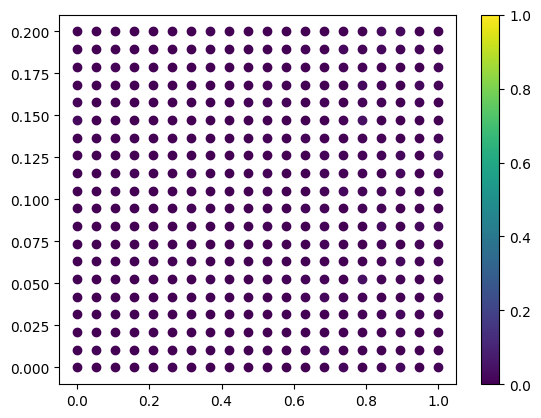

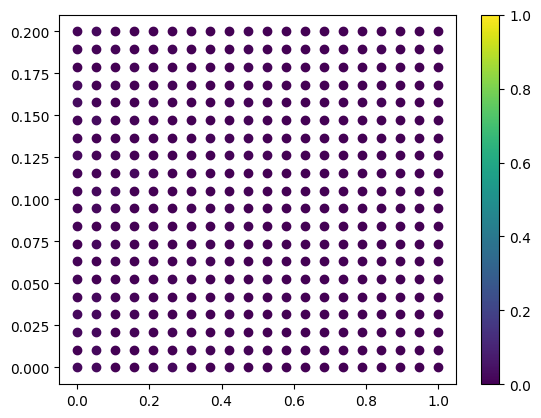

In [54]:
Z_L=0
for SNRRR in [16,24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            
            all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_SIS_{1}_data_{I_tt}_{dtt}_{SNRRR}.npy')
            all_x_vail=torch.tensor(all_x_vail_data,dtype=torch.float32)
            all_x_vail=get_wave_plus_gaosnoise_t_gen_cai(all_x_vail).reshape(-1,2)
            all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)

            y_pre_all=[]
            for i in range(100):
                estimator.eval()
                with torch.no_grad():
                    #print(all_x_vail[i].dtype)
                    y_pre = torch.sigmoid(estimator(all_x_vail[i].cuda()))
                y_pre_all.append(float(y_pre))
            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)


                        
    plt.colorbar()
    plt.show()

1


/tmp/ipykernel_231880/1279666974.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


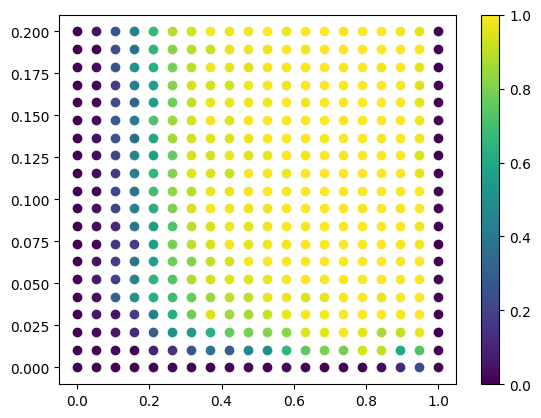

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [ ]:
Z_L=0
for SNRRR in [16,24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            try:
                all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_SIS_{2}_data_{I_tt}_{dtt}_{SNRRR}.npy')
            except:
                print(1)
            
            all_x_vail=torch.tensor(all_x_vail_data,dtype=torch.float32)
            all_x_vail=get_wave_plus_gaosnoise_t_gen_cai(all_x_vail).reshape(-1,2)
            all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)

            y_pre_all=[]
            for i in range(100):
                estimator.eval()
                with torch.no_grad():
                    #print(all_x_vail[i].dtype)
                    y_pre = torch.sigmoid(estimator(all_x_vail[i].cuda()))
                y_pre_all.append(float(y_pre))
            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)


                        
    plt.colorbar()
    plt.show()

这段代码是对之前描述的过程的一个重复，但是针对不同的数据集（指定为`test_SIS1data...`）。它旨在评估和可视化模型在不同信噪比（SNR）、以及不同参数`I_tt`和`dtt`条件下对于另一组测试数据的预测性能。

### 主要步骤：
1. **设置信噪比（SNR）值**：通过迭代`[16,24]`，考察在不同信噪比条件下模型的表现。
2. **数据加载和预处理**：对每个SNR值，通过两层嵌套循环遍历`I_tt`和`dtt`的值，加载相应的测试数据。使用`get_wave_plus_gaosnoise_t_gen_cai`函数对测试数据进行预处理，以符合模型输入的要求。
3. **模型预测**：对预处理后的每个测试样本，使用`estimator`模型进行预测。使用sigmoid函数将模型的输出转换为概率值。
4. **二分类预测**：根据设定的阈值（0.8），将概率值转换为二元标签（0或1），代表不同的分类结果。
5. **结果可视化**：将每个`I_tt`和`dtt`参数组合下的平均预测结果（即，预测为类别1的比例）通过散点图的颜色深度展示出来。颜色深度反映了在该参数组合下，模型预测为类别1的比例。
6. **展示图表**：对每个SNR值，展示一个图表，使用颜色条来指示颜色深度与预测概率之间的对应关系。

### 目的和应用：
- **评估模型性能**：这个过程主要用于评估`estimator`模型在处理特定物理过程（如重力波信号）中的表现，特别是如何随着不同物理参数（`I_tt`和`dtt`）和信噪比（SNR）的变化而变化。
- **理解模型行为**：通过在多个参数维度上的系统评估，可以更好地理解模型对于输入数据的变化敏感度，从而为模型的改进和应用提供指导。

### 注意事项：
- 此代码段假定你已经有了适当的导入和定义，包括`matplotlib`库的导入（`import matplotlib.pyplot as plt`），以及`get_wave_plus_gaosnoise_t_gen_cai`函数和`estimator`模型的定义。
- 在进行大量的模型评估和图表生成时，需要考虑计算资源的使用，特别是GPU资源，因为每个测试样本的预测都在CUDA设备上进行。

1


/tmp/ipykernel_231880/2973737464.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


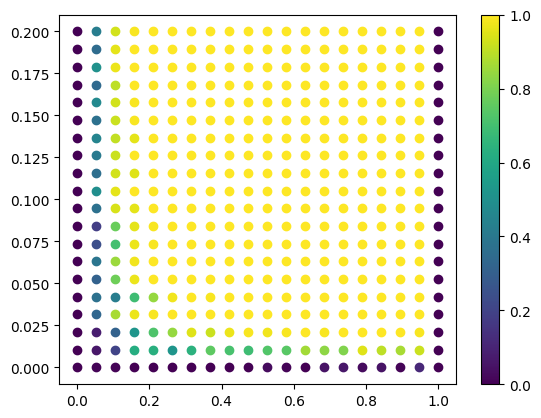

In [56]:
Z_L=0
for SNRRR in [24]:
    plt.figure()
    for I_tt in np.linspace(0,1,20):
        for dtt in np.linspace(0,0.2,20):
            try:
                all_x_vail_data=np.load(f'/home/DATA/suntianyang/gw_len/data/I_dt/test_SIS_{2}_data_{I_tt}_{dtt}_{SNRRR}.npy')
            except:
                print(1)
            
            all_x_vail=torch.tensor(all_x_vail_data,dtype=torch.float32)
            all_x_vail=get_wave_plus_gaosnoise_t_gen_cai(all_x_vail).reshape(-1,2)
            all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)

            y_pre_all=[]
            for i in range(100):
                estimator.eval()
                with torch.no_grad():
                    #print(all_x_vail[i].dtype)
                    y_pre = torch.sigmoid(estimator(all_x_vail[i].cuda()))
                y_pre_all.append(float(y_pre))
            
            threshold = 0.8
            # 根据阈值确定预测标签
            y_pre = (np.array(y_pre_all) >= threshold).astype(int)
            plt.scatter(I_tt,dtt,c=sum(y_pre)/100, vmin=0, vmax=1)


                        
    plt.colorbar()
    plt.show()

这段代码进一步深化了之前的分析过程，但仅针对一个特定的信噪比（SNR）值24，以及处理了数据加载过程中可能出现的异常情况。以下是关键步骤的解读：

### 关键步骤解读：

1. **单一信噪比值**：循环仅考虑一个SNR值24，这可能是基于先前结果的分析，决定更详细地探索此SNR值下模型的表现。

2. **异常处理**：使用`try-except`块尝试加载数据文件，如果文件不存在或其他原因导致加载失败，则捕获异常并打印`1`（作为错误指示）。这是数据处理过程中常见的健壮性增强手段，能够避免因单个文件的缺失或损坏而中断整个程序。

3. **数据预处理与模型评估**：对于每个成功加载的数据集，首先通过之前定义的`get_wave_plus_gaosnoise_t_gen_cai`函数进行预处理，然后使用`estimator`模型对处理后的数据进行预测。这一部分与之前的代码相同。

4. **阈值判断与可视化**：根据阈值0.8将模型的预测输出转换为二元标签，随后使用`plt.scatter`绘制散点图，其中每个点的颜色表示在当前`I_tt`和`dtt`参数组合下，模型将测试样本预测为类别1的比例。

5. **图表展示**：对每一组参数组合绘制的散点图最终以颜色图的形式呈现，颜色条展示了预测为类别1的比例与颜色深度的对应关系，从而直观展示了模型在不同参数条件下的预测性能。

### 目的与应用：

- **性能分析**：这个过程旨在深入理解模型在特定信噪比（24）下对于不同物理参数（`I_tt`和`dtt`）的敏感度，有助于评估模型在实际应用场景中的适用性和可靠性。

- **参数优化**：通过系统地评估不同参数组合下的模型表现，可以为模型的进一步优化提供指导，特别是在物理模拟和信号处理等领域。

### 注意事项：

- 确保在实际应用中适当地处理异常，避免因单个数据点的问题影响整体分析过程。
- 在进行大规模的模型评估和图表生成时，需要注意计算资源的分配和管理，尤其是GPU资源的有效使用。
- 在最终的可视化展示中，应确保图表清晰地传达了预测结果的信息，包括正确配置颜色条和标签，以便观察者可以轻松地解读结果。